In [53]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import pyprojroot
import importlib
import janitor
import pyreadr
sys.path.append(str(pyprojroot.here()))
import src.pandas_missing_extension
importlib.reload(src.pandas_missing_extension)
from src.utils import make_dir_function
from src.pandas_missing_extension import MissingMethods

#### Imputation based on context

In [54]:
implicit_to_explicit_df = pd.DataFrame(
    data={
        "name": ["lynn", np.nan, "zelda", np.nan, "shadowsong", np.nan],
        "time": ["morning", "afternoon", "morning", "afternoon", "morning", "afternoon",],
        "value": [350, 310, 320, 350, 310, 320]
    }
)

implicit_to_explicit_df

,name,time,value
0,lynn,morning,350
1,NaN,afternoon,310
2,zelda,morning,320
3,NaN,afternoon,350
4,shadowsong,morning,310
5,NaN,afternoon,320


In [55]:
implicit_to_explicit_df.ffill()

,name,time,value
0,lynn,morning,350
1,lynn,afternoon,310
2,zelda,morning,320
3,zelda,afternoon,350
4,shadowsong,morning,310
5,shadowsong,afternoon,320


#### Imputation of a single value

In [56]:
data_dir = make_dir_function("data")
riskfactor_file = data_dir("raw", "riskfactors.rda")

In [57]:
riskfactors_df = pyreadr.read_r(riskfactor_file)['riskfactors']

In [58]:
selected_columns_df = riskfactors_df.filter(items=["weight_lbs", "height_inch", "bmi"])
print(selected_columns_df.isnull().sum())

weight_lbs     10
height_inch     2
bmi            11
dtype: int64


In [59]:
selected_columns_df.missing.bind_shadow_matrix(
    true_string=True,
    false_string=False
).apply(
    axis='rows',
    func= lambda column: column.fillna(column.mean())
).isnull().sum()

weight_lbs        0
height_inch       0
bmi               0
weight_lbs_NA     0
height_inch_NA    0
bmi_NA            0
dtype: int64

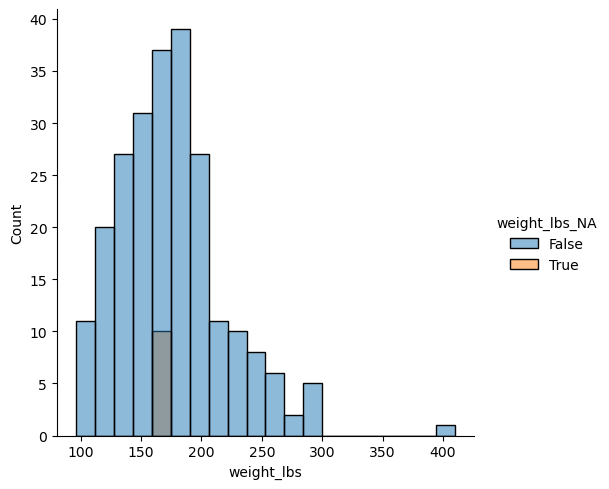

In [60]:
selected_columns_df.missing.bind_shadow_matrix(
    true_string=True,
    false_string=False
).apply(
    axis='rows',
    func= lambda column: column.fillna(column.mean())
).pipe(
    lambda df: (
        sns.displot(
            data=df,
            x="weight_lbs",
            hue="weight_lbs_NA",
        )
    )
)

#### Imputation of multiple variables

<AxesSubplot:xlabel='weight_lbs', ylabel='height_inch'>

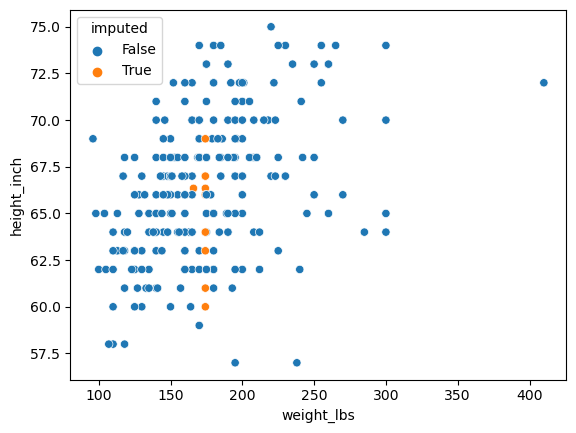

In [61]:
selected_columns_df.missing.bind_shadow_matrix(
    true_string=True,
    false_string=False
).apply(
    axis='rows',
    func= lambda column: column.fillna(column.mean())
).assign(
    imputed = lambda df: df.weight_lbs_NA | df.height_inch_NA
).pipe(
    lambda df: (
        sns.scatterplot(
            data=df,
            x="weight_lbs",
            y="height_inch",
            hue="imputed"
        )
    )
)

#### Multiple imputation visualization

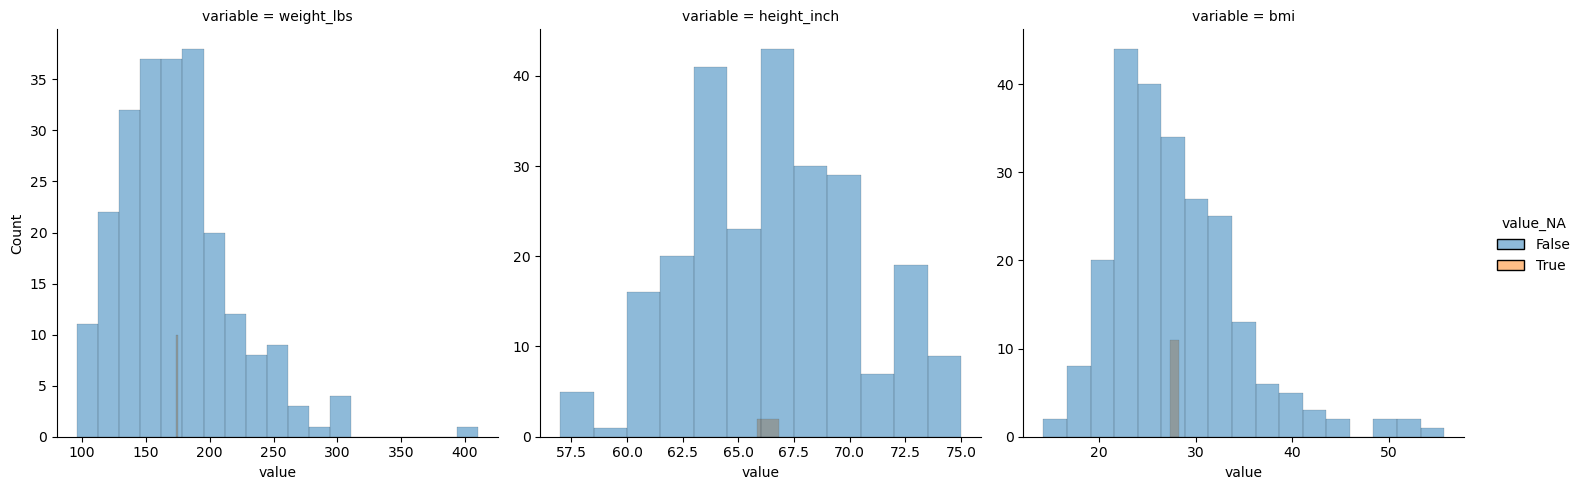

In [70]:
selected_columns_df.missing.bind_shadow_matrix(
    true_string=True,
    false_string=False
).apply(
    axis='rows',
    func= lambda column: column.fillna(column.mean())
).pivot_longer(
    index="*_NA"
).pivot_longer(
    index=["variable", "value"],
    names_to="variable_NA",
    values_to="value_NA"
).assign(
    valid= lambda df: df.apply(
        axis='columns', func=lambda column: column.variable in column.variable_NA
    )
).query(
    "valid"
).pipe(
    lambda df: sns.displot(
        data=df,
        x="value",
        hue="value_NA",
        col="variable",
        common_bins=False,
        facet_kws={"sharex": False, "sharey": False}
    )
)